In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

/media/ubuntu/My Book/Preprocessed/UST21/Chl-a/Train/perfect/UST21_L3_Merged-Chla-1D_2012_r6656_c1536.tiff


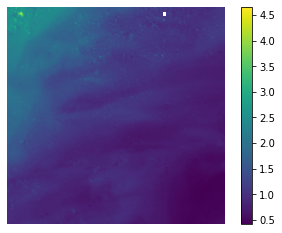

In [35]:
img = input()
img = cv2.imread(img,cv2.IMREAD_UNCHANGED)
plt.imshow(img)
plt.axis(False)
plt.colorbar()

In [34]:
np.sum(np.isnan(img))/(256**2)*100

0.49896240234375

In [28]:
256*256

65536